In [34]:
import tensorflow as tf
from tensorflow.keras import models, layers
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.10.0


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU kullanılabilir: ", gpus)
else:
    print("GPU kullanılabilir değil.")

GPU kullanılabilir:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]) # 1024 MB olarak belirlendi
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Fiziksel GPU(lar),", len(logical_gpus), "Mantıksal GPU(lar)")
    except RuntimeError as e:
        print(e)

1 Fiziksel GPU(lar), 1 Mantıksal GPU(lar)


In [5]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS=35

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Tomato",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [7]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

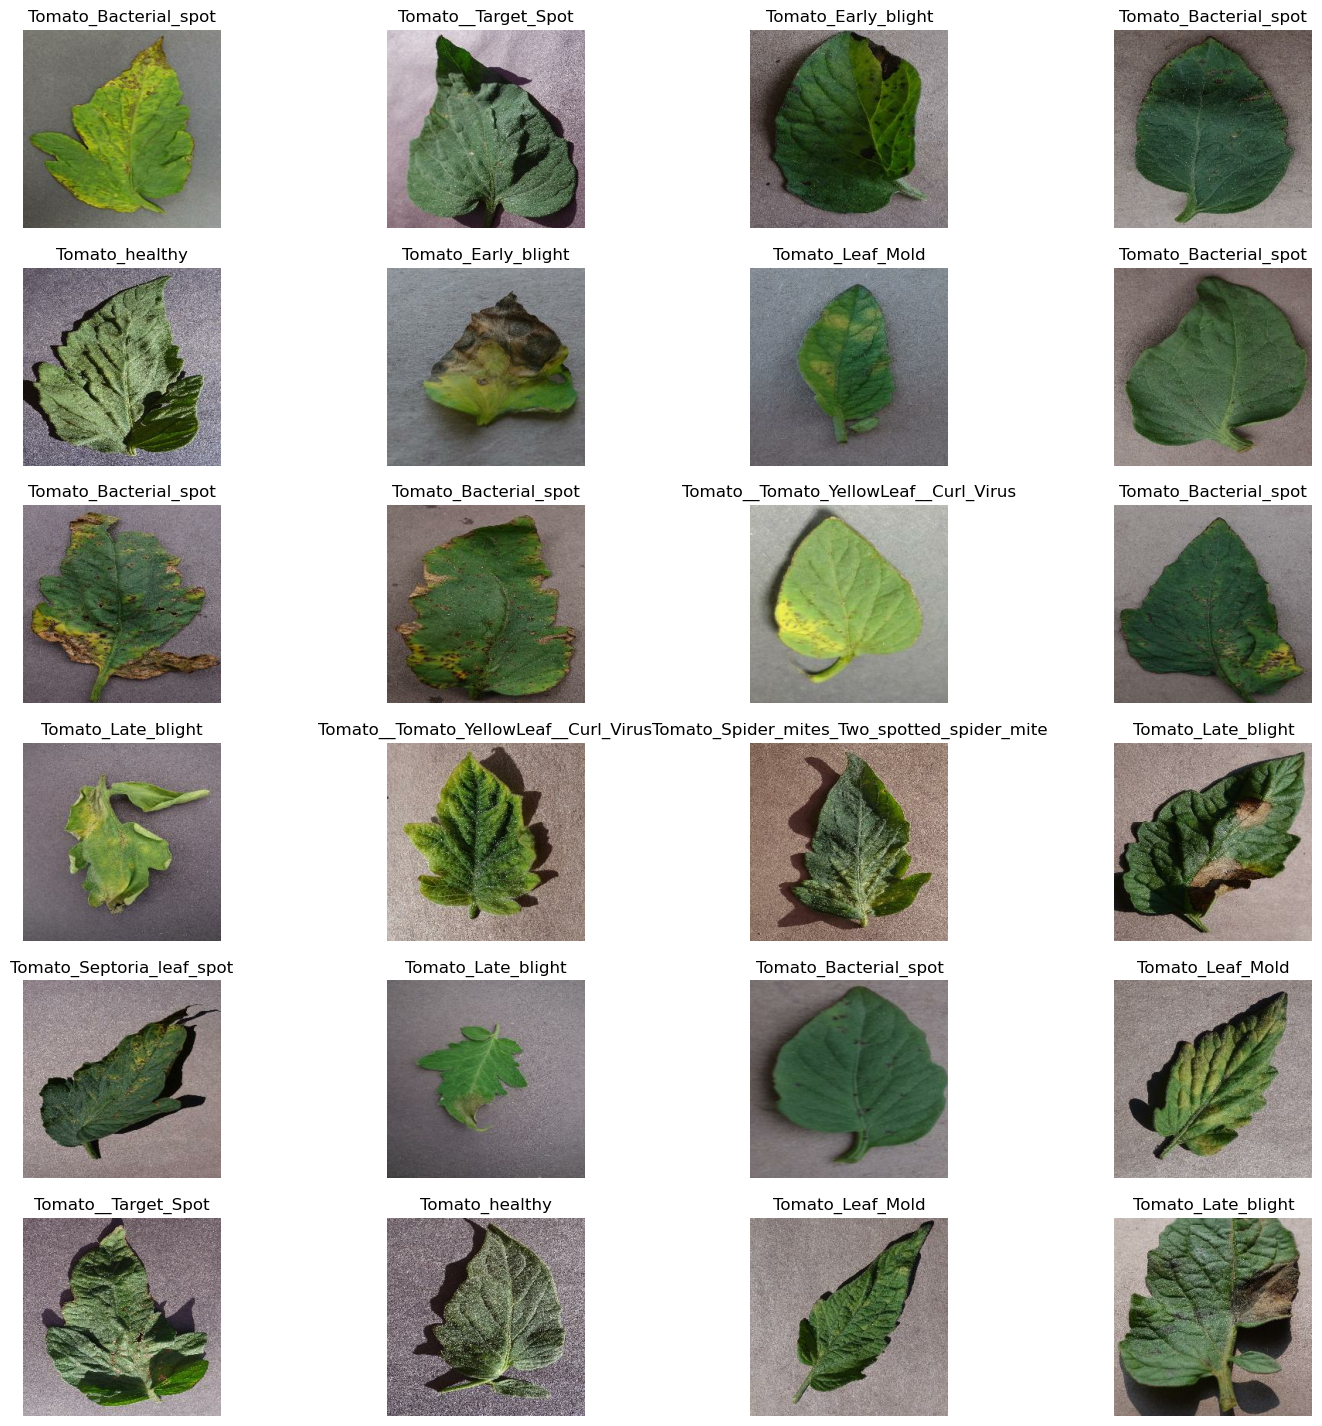

In [8]:
plt.figure(figsize = (18,18))
for image_batch, label_batch in dataset.take(1):
    for i in range(24):
        ax = plt.subplot(6,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 7)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
len(train_ds)

400

In [12]:
len(val_ds)

50

In [13]:
len(test_ds)

51

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [15]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [16]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10 

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax')
])

In [18]:
model.build(input_shape=input_shape)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [20]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [21]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/35
400/400 [==============================] - 112s 224ms/step - loss: 1.7451 - accuracy: 0.3780 - val_loss: 1.5601 - val_accuracy: 0.4219
Epoch 2/35
400/400 [==============================] - 67s 168ms/step - loss: 1.0156 - accuracy: 0.6411 - val_loss: 1.0816 - val_accuracy: 0.6100
Epoch 3/35
400/400 [==============================] - 54s 136ms/step - loss: 0.6644 - accuracy: 0.7631 - val_loss: 0.9599 - val_accuracy: 0.6619
Epoch 4/35
400/400 [==============================] - 55s 138ms/step - loss: 0.4784 - accuracy: 0.8287 - val_loss: 1.2326 - val_accuracy: 0.6400
Epoch 5/35
400/400 [==============================] - 56s 139ms/step - loss: 0.3985 - accuracy: 0.8596 - val_loss: 0.6667 - val_accuracy: 0.7625
Epoch 6/35
400/400 [==============================] - 55s 138ms/step - loss: 0.3332 - accuracy: 0.8807 - val_loss: 0.7278 - val_accuracy: 0.7475
Epoch 7/35
400/400 [==============================] - 56s 139ms/step - loss: 0.2831 - accuracy: 0.8991 - val_loss: 0.8761 - val_a

In [23]:
scores = model.evaluate(test_ds)

51/51 [==============================] - 1s 24ms/step - loss: 0.4232 - accuracy: 0.8885


In [24]:
scores

[0.42323774099349976, 0.8884803652763367]

In [25]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

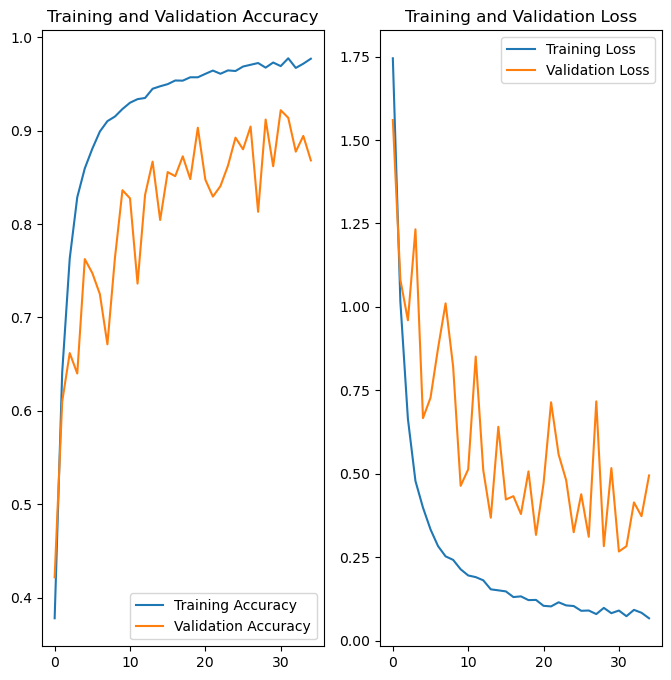

In [26]:
plt.figure(figsize = (8, 8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

first image to predict
first images actual label: Tomato__Target_Spot
1/1 [==============================] - 0s 167ms/step
Tomato__Target_Spot


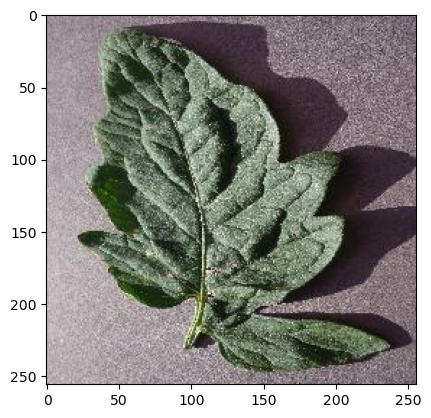

In [27]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("first images actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print(class_names[np.argmax(batch_prediction[0])])

In [30]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 13ms/step


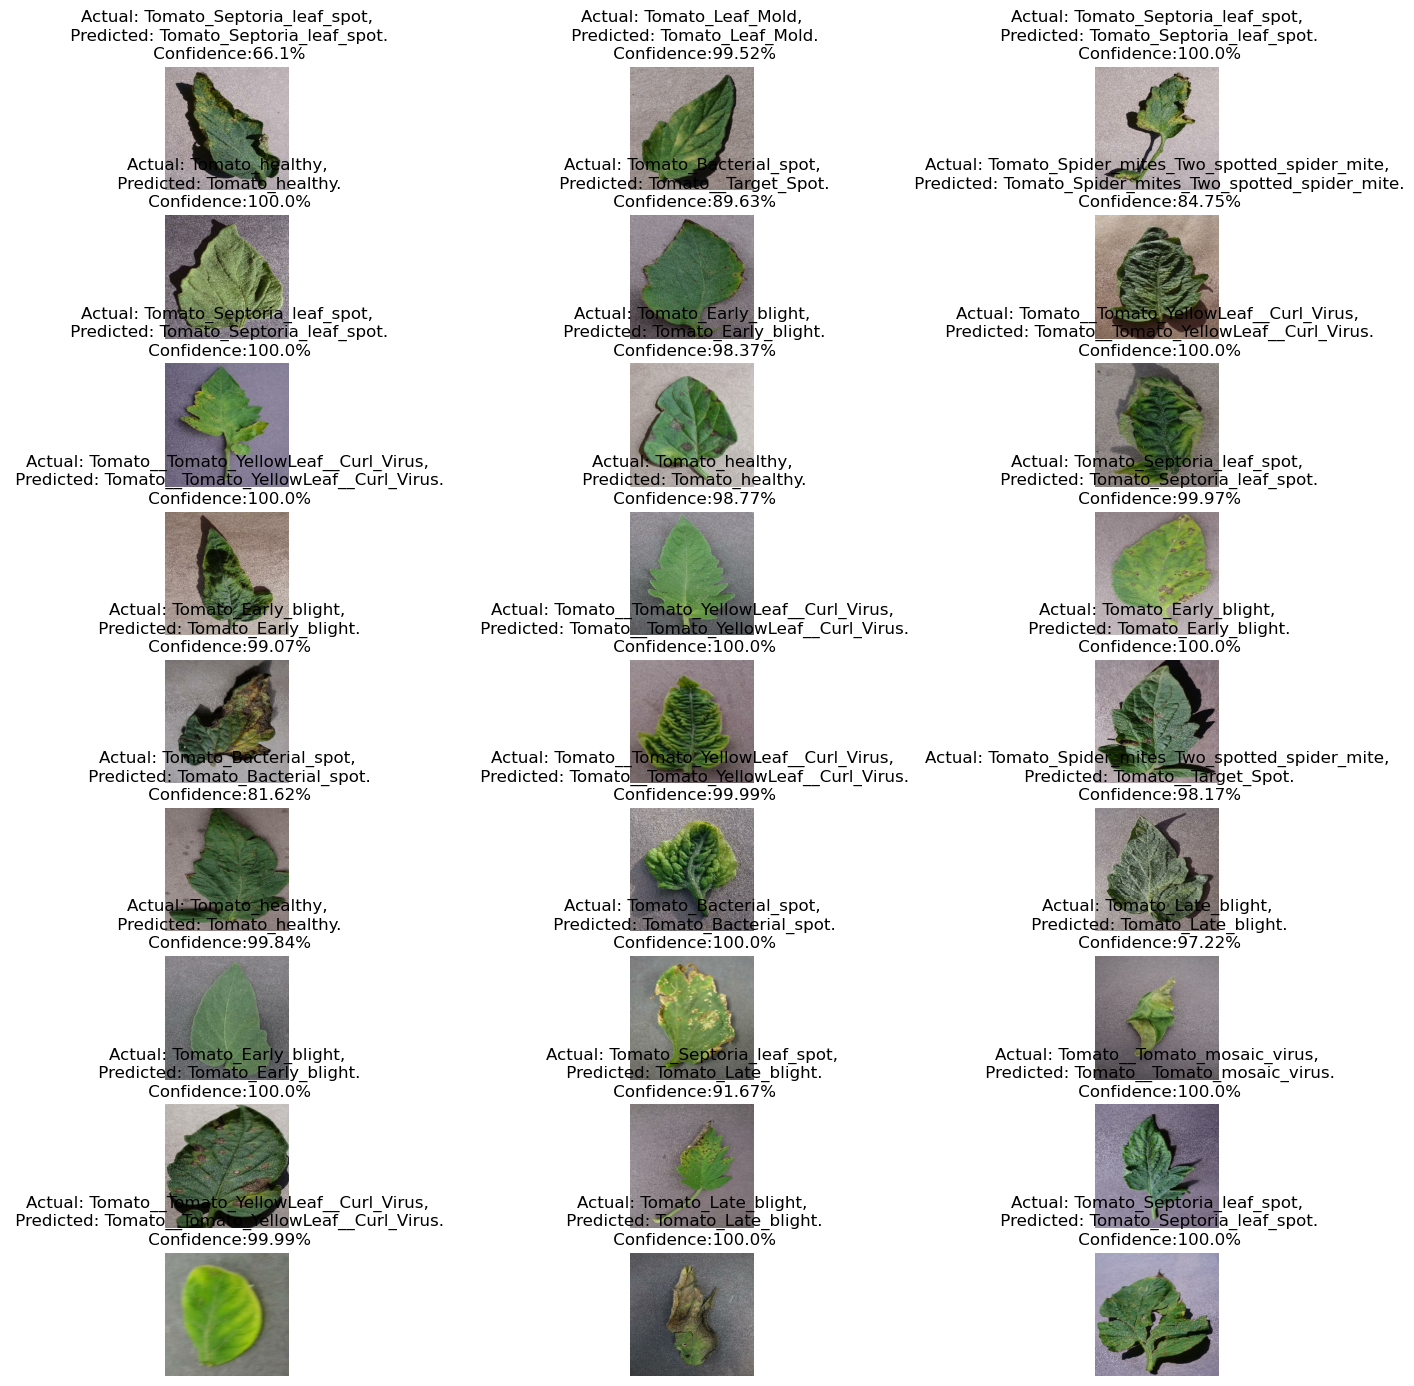

In [41]:
plt.figure(figsize = (17,17))
for images, labels in test_ds.take(1):
    for i in range(27):
        ax = plt.subplot(9, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence:{confidence}%")
        
        plt.axis("off")
        

In [42]:
model_version=1
model.save("../models/2.keras")